In [1]:
# % matplotlib notebook 
from IPython.display import IFrame, display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib          import rc 
from matplotlib          import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import os.path as path
import wget
from scipy.stats import norm

In [2]:
def GetHisto(l,NChannels,h = 1):
    h = 1.
    bins = np.arange(1,NChannels+2*h,h)
    w = np.diff(bins)
    m = bins[:-1] + 0.5*w[0] # marcas de clase
    return l,m,w

In [3]:
def GetHisto2(l, h = 0.1, norm=True):
    
    min_=np.min(l)
    max_=np.max(l)
    
    x = np.arange(min_,max_+h,h)
    
    H, bines = np.histogram(l,bins=x)
    w = np.diff(bines)
    m = bines[:-1] + 0.5*w[0] # marcas de clase
    
    if norm:
        H = H / (np.sum(H*w))
    
    return H,bines,m,w

In [4]:
!rm Data/*
file = 'Data/data.csv'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/ObsExtraT.csv'
if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

File loaded


In [5]:
Df = pd.read_csv(Path_,sep = ',')
print(Df)

   NData  NBkg  NSignal1  NSignal2
0     10     9        10         3
1     20    17        15         6
2     10     5        10         3
3      6     6         4         1


In [6]:
n = np.array(Df.NData)
b = np.array(Df.NBkg)
s = np.array(Df.NSignal2)
NChannels = len(n)

In [7]:
# Definimos el rango de los histogramas
HData,m,w = GetHisto(n, NChannels)
ErrorData = np.sqrt(HData) # Error poisson

HBkg,m,w = GetHisto(b, NChannels)
HSignal,m,w = GetHisto(s, NChannels)

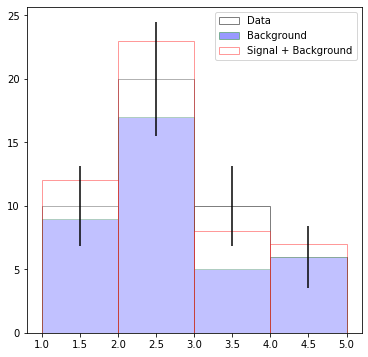

In [8]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.bar(m,HData,yerr=ErrorData, color='w', width=w, ec='k', label='Data', alpha=0.5)
ax.bar(m,HBkg, color='b' ,width=w, ec='g', label='Background', alpha=0.4)
ax.bar(m,HBkg+HSignal, color='w' ,width=w, ec='r', label='Signal + Background', alpha=0.4)
ax.legend(loc=0)

In [9]:
def GetLnQ(n,b,s,mu):
    return 2*(mu*s - n*np.log(1+mu*s/b))

In [10]:
def JointLnQ(NChannels, GetLnQ, mu, Null=True):
    
    Q = 0.
    
    for c in range(NChannels):
        
        if Null == True:
            ntoy = np.random.poisson( b[c] ) # Hipotesis nula 
        else:
            ntoy = np.random.poisson( b[c] + mu*s[c] ) # Hipotesis alternativa
            
        Q += GetLnQ(ntoy,b[c],s[c],mu)
        
    return Q

In [11]:
def JointObsLnQ(NChannels, GetLnQ, mu):
    
    Q = 0.
    
    for c in range(NChannels):
        
        Q += GetLnQ(n[c],b[c],s[c],mu)
        
    return Q
    

In [12]:
ObsLnQ = JointObsLnQ( NChannels, GetLnQ, 1.0 )
print(ObsLnQ)

-3.0947570667947764


In [13]:
def GetPvalue(H,bins,Obs):
    
    w = np.diff(bins)
    
    ii = bins[:-1] > Obs
    
    p = np.sum( H[ii]*w[ii]  )
    
    return p

In [14]:
def Sampler(mu, Ntoys = int(3e4)):
    
    q0 = np.zeros(Ntoys)
    q1 = np.zeros(Ntoys)
    
    for i in range(Ntoys):
        
        q0[i] =  JointLnQ( NChannels, GetLnQ, mu )
        q1[i] =  JointLnQ( NChannels, GetLnQ, mu, Null = False )
        
    return q0,q1

In [15]:
q0, q1 = Sampler(1.0)

In [16]:
H0,bines,m,w = GetHisto2(q0,h=0.001)
H1,bines1,m1,w1 = GetHisto2(q1,h=0.001)

In [17]:
Clb = GetPvalue(H0,bines,ObsLnQ)
Clsb = GetPvalue(H1,bines1,ObsLnQ)

In [18]:
p0 = 1 - Clb
p1 = Clsb
print(p0,p1)
Cls = Clsb/Clb
print(Cls)

0.035633333333333184 0.3896666666666666
0.4040648439390272


In [19]:
print( norm.ppf(1-Clb), norm.ppf(1-Clsb) )

-1.8037744889607379 0.28018792099074474


In [20]:
# Lo observado tiene un corrimiento a 1.5sigma de la hipotesis nula
# Lo observado tiene un corrimiento a 3.3sigma de la hipotesis alternativa

# Hacer scan en mu para en contral el upper limit

In [21]:
#plt.hist(q0, bins = 50)
#plt.hist(q1, bins = 50)
#plt.axvline(x = ObsLnQ, color='k')

In [22]:
def GetUpper(mu):
    
    pvalue = np.zeros(len(mu))
    
    for i in tqdm(range(len(mu))):
        
        ObsLnQ = JointObsLnQ( NChannels, GetLnQ, mu[i] )
        q0,q1 = Sampler(mu[i])
        
        H0,bines,m,w = GetHisto2(q0,h=0.001)
        H1,bines1,m1,w1 = GetHisto2(q1,h=0.001)
        
        Clb = GetPvalue(H0,bines,ObsLnQ)
        Clsb = GetPvalue(H1,bines1,ObsLnQ)
        
        Cls = 0.
        
        if Clb != 0.:
            Cls = Clsb/Clb
            
        pvalue[i] = Cls
        
    return pvalue

In [23]:
mu = np.linspace(0.9,2,20)
pvalue = GetUpper(mu)

100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


In [27]:
print(pvalue)
print(mu)

[0.48015312 0.43538143 0.38139776 0.34790415 0.30617395 0.27281527
 0.23737601 0.20489762 0.17490995 0.15092321 0.12571072 0.1075507
 0.08973871 0.07532261 0.06329815 0.04831904 0.04382166 0.03127054
 0.02606561 0.02092629]
[0.9        0.95789474 1.01578947 1.07368421 1.13157895 1.18947368
 1.24736842 1.30526316 1.36315789 1.42105263 1.47894737 1.53684211
 1.59473684 1.65263158 1.71052632 1.76842105 1.82631579 1.88421053
 1.94210526 2.        ]


In [30]:
ii = pvalue < 0.05
jj = pvalue > 0.03
upper = mu[ii & jj][0]
print(upper)

1.7684210526315791


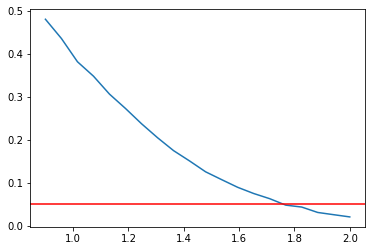

In [29]:
plt.plot(mu,pvalue)
plt.axhline(y=0.05,color='r')